## Accessing Sentinel-2 L2A data with the Planetary Computer STAC API

The [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) program provides global imagery in thirteen spectral bands at 10m-60m resolution and a revisit time of approximately five days.  This dataset represents the global Sentinel-2 archive, from 2016 to the present, processed to L2A (bottom-of-atmosphere) using [Sen2Cor](https://step.esa.int/main/snap-supported-plugins/sen2cor/) and converted to [cloud-optimized GeoTIFF](https://www.cogeo.org/) format.  The digital elevation model used for terrain correction was [Planet DEM 30](https://planetobserver.com/global-elevation-data/).

This notebook demonstrates the use of the Planetary Computer STAC API to query for Sentinel-2 tiles.

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. The Planetary Computer Hub is pre-configured to use your API key.

In [1]:
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Choose a region and time of interest

This area is near Jonah Bay, Alaska.

In [3]:
# area_of_interest = {
#     "type": "Polygon",
#     "coordinates": [
#         [
#             [-148.56536865234375, 60.80072385643073],
#             [-147.44338989257812, 60.80072385643073],
#             [-147.44338989257812, 61.18363894915102],
#             [-148.56536865234375, 61.18363894915102],
#             [-148.56536865234375, 60.80072385643073],
#         ]
#     ],
# }

# area_of_interest = {
#     "type": "Polygon",
#     "coordinates": 
#     [[[-77.4, 17.9], 
#       [-77.125, 17.9], 
#       [-77.4, 17.725], 
#       [-77.125, 17.753479383833962]]]
# }

#working:
area_of_interest = {
    "type": "Polygon",
    "coordinates": 
    [[[-77.4, 17.725], 
      [-77.4, 17.9], 
      [-77.125, 17.9], 
      [-77.125, 17.725], 
      [-77.4, 17.725]]]
}

# area_of_interest = {
#     "type": "Polygon",
#     "coordinates": 
#     [[[-77.7, 17.5], 
#       [-77.7, 18.1], 
#       [-77, 18.1], 
#       [-77, 17.5], 
#       [-77.7, 17.5]]]
# }

Define the time range to filter images with. Here we use the summer of 2019.

In [4]:
time_of_interest = "2022-03-01/2022-04-01"

In [5]:
from odc.stac import stac_load
import rasterio.features



search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

# Check how many items were returned
items = search.item_collection()
print(f"Returned {len(items)} Items")



# items = min(items, key=lambda item: eo.ext(item).cloud_cover)

# print(
#     f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
#     f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
# )



bbox = rasterio.features.bounds(area_of_interest)

#13 bands
cfg = {
    "sentinel-2-l2a": {
        "assets": {
            "*": {"data_type": "uint16", "nodata": 0},
            "SCL": {"data_type": "uint8", "nodata": 0},
            "visual": {"data_type": "uint8", "nodata": 0},
        },
    },
    "*": {"warnings": "ignore"},
}

band_ls = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09','B11', 'B12']

xx = stac_load(
    items,
    bands=band_ls,
    resolution=10,
    bbox = bbox,
    chunks={"x": 128, "y": 128},
    stac_cfg=cfg,
    patch_url=planetary_computer.sign,
)

# median = xx.median(dim="time").compute()
median = xx.mean(dim="time").compute()

Returned 1 Items


/home/mpham/.local/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/home/mpham/.local/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


In [6]:
# median.to_netcdf('jamaica2-03-2022.tif')


median.to_array().odc.write_cog(
    'jamaica3-03-2022.tif',
    overwrite=True
)

PosixPath('jamaica3-03-2022.tif')

In [7]:
from rasterio.plot import reshape_as_raster, reshape_as_image

img = reshape_as_image(median.to_array().to_numpy())
img_raster = reshape_as_raster(median.to_array().to_numpy())

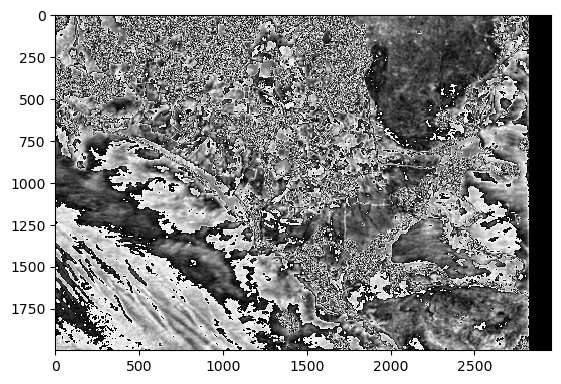

In [8]:
from einops import rearrange
import matplotlib.pyplot as plt
import numpy as np

array = median.to_array().to_numpy()
array = rearrange(array, 'c w h -> w h c')

array = np.array(img)
# print(array.shape)
# max_vals = np.amax(array)
# print(max_vals)

bands_to_display = [0]*3
selected_bands = array[:, :, bands_to_display]

plt.imshow((selected_bands).astype(np.uint8))
plt.show()

Choosing S2B_MSIL2A_20220320T154549_R111_T17QRV_20220321T044637 from 2022-03-20 with 9.215028% cloud cover


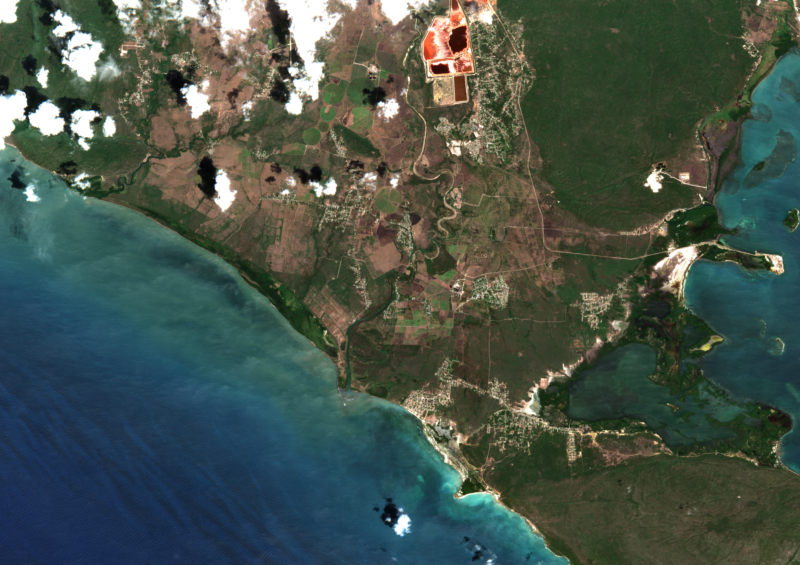

In [9]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image

least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
)

asset_href = least_cloudy_item.assets["visual"].href


with rasterio.open(asset_href) as ds:
    aoi_bounds = features.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)

img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
w = img.size[0]
h = img.size[1]
aspect = w / h
target_w = 800
target_h = (int)(target_w / aspect)
img.resize((target_w, target_h), Image.Resampling.BILINEAR)

In [10]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from rasterio.plot import reshape_as_raster, reshape_as_image
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.plot import show

In [11]:
path_directory = 'ml-mangrove-data2/'


nm_shp = gpd.read_file(path_directory + "JamaicaNonmangroveLabels.shp")
m_shp = gpd.read_file(path_directory + "JamaicaMangroveLabelsFixed.shp")

nm_shp = nm_shp.to_crs(epsg=32617)
m_shp = m_shp.to_crs(epsg=32617)

nm_geoms = nm_shp.geometry
m_geoms = m_shp.geometry

In [12]:
src = rasterio.open("jamaica3-03-2022.tif") 
mask_src = rasterio.open(path_directory +"JamaicaImageMask.tif") 

#Getting mask for each class
mmask, mmask_transform = mask(mask_src, m_geoms, crop=True)
nmmask, nmmask_transform = mask(mask_src, nm_geoms, crop=True)


In [13]:
# print(src.crs.data)
# print(nm_shp.crs)
# nm_shp = nm_shp.to_crs(src.crs.data)
# print(nm_shp.crs)



In [15]:
nm_shp = nm_shp.to_crs(epsg=32617)
m_shp = m_shp.to_crs(epsg=32617)

nm_image, nm_transform = mask(src, nm_geoms, crop=True)
m_image, m_transform = mask(src, m_geoms, crop=True) 


ValueError: Input shapes do not overlap raster.

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

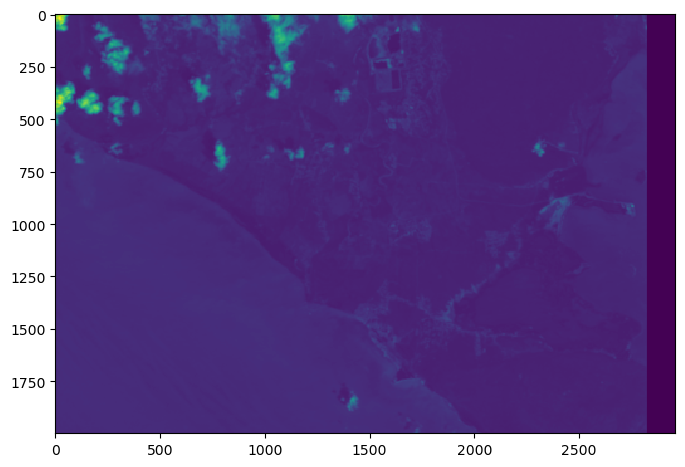

In [21]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.plot import show

img = src.read(1)  # Read the first band (change the band index if needed)

# Step 2: Load the geometries from the shapefile
# Replace 'shapefile_path' with the path to your shapefile
# m_geoms = m_shp.geometry

# Step 3: Create a plot of the GeoTIFF image
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Step 4: Overlay the geometries from the shapefile on the plot
show(img, ax=ax, cmap='viridis')  # Display the GeoTIFF image
mmask.plot(ax=ax, color='none', edgecolor='blue', linewidth=1)  # Overlay all shapefile geometries' boundaries in blue

# Show the overlaid image
plt.show()

In [16]:
print(src.crs.data)
print(nm_shp.crs)


{'init': 'epsg:32617'}
EPSG:32617


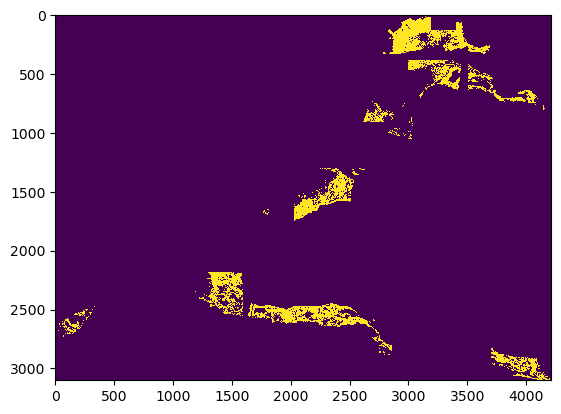

In [ ]:
show(mmask) 

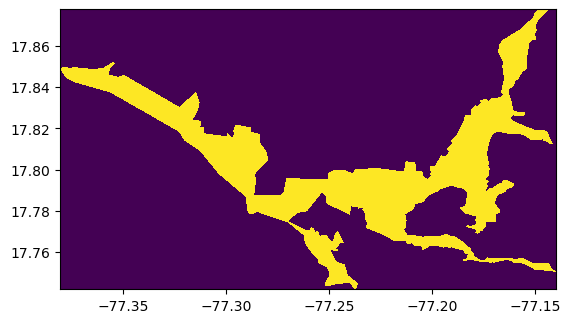

In [ ]:
show(mask_src) 

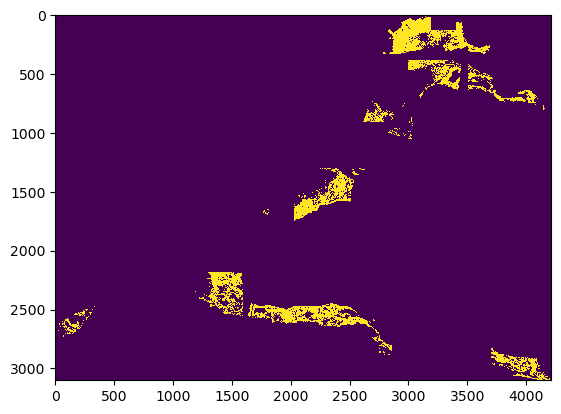

In [ ]:
show(mmask)

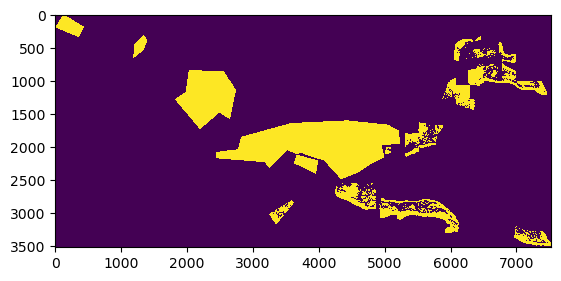

In [ ]:
show(nmmask)

In [ ]:
m_idx = np.squeeze(((reshape_as_image(mmask) == 1)), axis=-1) 
nm_idx = np.squeeze((reshape_as_image(nmmask) == 1), axis=-1)

m_pix = reshape_as_image(m_image)[m_idx]
nm_pix = reshape_as_image(nm_image)[nm_idx]

m_pix = m_pix[np.all(m_pix != 0, axis=1)]
nm_pix = nm_pix[np.all(nm_pix != 0, axis=1)]

x = np.concatenate((m_pix, nm_pix), axis = 0)
y = np.concatenate((np.zeros((m_pix.shape[0]))+1, np.zeros((nm_pix.shape[0]))))

In [ ]:
type(src)

rasterio.io.DatasetReader